In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import esutil, scipy
sys.path.append('../')
from utils import *
from cmass_modules import io, Cuts
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def z_gaussian(mu, sigma, bins):
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))

def z_gaussians(A, bins):

    sigma1 = 0.07
    sigma2 = 0.2
    mu1 = 0.59
    mu2 = 0.35
    g1 = 1./(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu1)**2 / (2 * sigma1**2))
    g2 = 1./(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu2)**2 / (2 * sigma2**2))
    
    return A*g1 + (1.0-A) * g2

In [3]:
def log_interp(x, y):
    """
    Log interpolation
    """
    s = scipy.interpolate.interp1d(log(x), log(y))
    x0 = x[0]
    y0 = y[0]
    x1 = x[-1]
    y1 = y[-1]

    def interpolator(xi):
        w1 = xi == 0
        w2 = (xi > 0) & (xi <= x0)
        w3 = xi >= x1
        w4 = ~ (w1 | w2 | w3)

        y = np.zeros_like(xi)
        y[w2] = y0 * (x0 / xi[w2])
        y[w3] = y1 * (x1 / xi[w3])**3
        y[w4] = exp(s(log(xi[w4])))
        return y
    return interpolator

def interp_2d( x, y, z):
    f = scipy.interpolate.interp2d(x, y, z, kind='cubic')
    return f

def cl_to_w(ell, c_ell, theta):
    """
    Fourier transform
    # theta unit : degree
    """
    theta = np.radians(theta)
    cl_interp = log_interp(ell, c_ell)
    ell_max = int(ell.max())
    ell_max_integral = 200000
    ell_sample = np.arange(ell_max_integral) * 1.0
    c_ell_sample = np.zeros(ell_max_integral)
    c_ell_sample = cl_interp(ell_sample)
#    for i,ell_i in enumerate(ell_sample):
#        c_ell_sample[i] = cl_interp(ell_i)

    f = (2 * ell_sample + 1) / (4 * pi)
    w = np.zeros_like(theta)
    for i, t in enumerate(theta):
        p_ell, _ = scipy.special.lpn(ell_max_integral - 1, cos(t))
        w[i] = (f * p_ell * c_ell_sample).sum()
    return w

In [4]:
zbin,dz = np.linspace(0.,10., 1001, retstep=True)
zcenter = zbin[:-1]+dz/2.
#Nz = np.column_stack(( zbin[:-1], N1, N2, N3, N4 ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/twomass.nz', Nz)
Nz = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/twomass.nz')
#Nz_cmass,_ = np.histogram( cmass_spec['Z'], bins=zbin, normed=True)
#Nz_cmass = np.column_stack(( zbin[:-1], Nz_cmass ))
Nz_cmass = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/cmass_ngc.nz')
N_2mass_all = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/twomass_1bin.nz')

def Pnz(z, i):
    from scipy.interpolate import interp1d
    zcenter = np.insert( Nz[:,0] + 0.005, 0, 0)
    nz = np.insert( Nz[:, i], 0, 0)
    pnz = interp1d(zcenter, nz)
    return pnz(z)

def Pnz_2mass_1bin(z, i):
    from scipy.interpolate import interp1d
    zcenter = np.insert( N_2mass_all[:,0] + 0.005, 0, 0)
    nz = np.insert( N_2mass_all[:, 1], 0, 0)
    pnz = interp1d(zcenter, nz)
    return pnz(z)


def Pnz_cmass(z, i):
    from scipy.interpolate import interp1d
    zcenter = np.insert( Nz_cmass[:,0] + 0.005, 0, 0)
    nz = np.insert( Nz_cmass[:, 1], 0, 0)
    pnz = interp1d(zcenter, nz)
    return pnz(z)

def Pnz_dmass(z, i, A=0.8):  
    """
    Two Gaussian Mixture
    A*G1 + (1-A)*G2
    """
    sigma1 = 0.07
    sigma2 = 0.18
    mu1 = 0.59
    mu2 = 0.4
    g1 = 1./(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu1)**2 / (2 * sigma1**2))
    g2 = 1./(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu2)**2 / (2 * sigma2**2))
    
    return A*g1 + (1.0-A) * g2

def _Pnz_dmass(z, i, A=0.8):  
    """
    Two Gaussian Mixture
    A*G1 + (1-A)*G2
    """
    sigma1 = 0.07
    sigma2 = 0.18
    mu1 = 0.59
    mu2 = 0.4
    g1 = 1./(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu1)**2 / (2 * sigma1**2))
    g2 = 1./(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu2)**2 / (2 * sigma2**2))
    
    pnzdistr = np.zeros(z.size)
    mask = (z<=0.4)
    
    g2[z<0.4] = Nz_cmass04
    
    #pnzdistr[mask] = A * Pnz_cmass(z, 1)[mask]
    #pnzdistr[z > 0.4] = g1[z > 0.4]
    return A*g1 + (1.0-A) * g2
    #return pnzdistr

In [5]:
from numpy import log, exp, cos, pi

def chi(a):
    return results.comoving_radial_distance(1./a -1.)/coverH0 * h0

def Ea(a):
    return results.hubble_parameter(1./a - 1.) * 1./pars.H0
    
def Wgal_2mass(a, indz):
    """
    2MASS kernel
    """
    z = 1./a -1.
    b_avg = [1.62, 1.52, 1.54, 1.65]
    wgal  = b_avg[indz-1] * Pnz(z, indz) * Ea(a)
    return wgal

def Wgal_2mass_1bin(a):
    """
    2MASS kernel
    """
    z = 1./a -1.
    b_avg_tot = 1.5927021517080193
    wgal  = b_avg_tot * Pnz_2mass_1bin(z, 1) * Ea(a)
    return wgal


def b_cmass(z):
    """
    
    bc = np.zeros(z.size)
    bc[z < 0.4] = 1.8
    bc[(z>=0.4) & (z < 0.45)] = 1.85
    bc[(z>=0.45) & (z < 0.55)] = 1.9
    bc[(z>=0.55) & (z < 0.65)] = 2.0
    bc[(z>=0.65)] = 2.1
    """
    
    
    inci = (2.1-1.8)/(0.72 - 0.15)
    k = 1.8 - inci * 0.15
    b = lambda z : inci * z + k

    return inci * z + k
    
def Wgal_cmass(a, indz):
    """
    cmass kernel
    """
    z = 1./a -1.
    #b_cmass = [2.0, 2.0, 2.0, 2.0]
    wgal  = b_cmass(z) * Pnz_cmass(z, 1) * Ea(a)
    return wgal
    #return 1.

def Wgal_dmass(a, indz, A=0.8):
    """
    dmass kernel
    Assume b = 2.0 for all z range.
    """
    z = 1./a -1.
    #b_cmass = [2.0, 2.0, 2.0, 2.0]
    wgal  = b_cmass(z) * Pnz_dmass(z, 1, A = A) * Ea(a)
    return wgal

def dchi_da(a):
    return 1./Ea(a)/a**2

def Pdelta(k, a):
    k = k/coverH0
    return PK.P(1./a -1., k)/(coverH0)**3

def int_for_Cl(ell, a, indz):
    
    k =  (ell+0.5) *1./chi(a)
    Pm =  np.array([Pdelta(k[i], a[i]) for i in range(k.size)])
    return Wgal_2mass(a,indz) * Wgal_2mass(a,indz) * dchi_da(a)/chi(a)**2 * Pm
 
def C_ell( ell, indz ):
    
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
        
    Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return Cl


def w_matter(theta, a):
    
    ellbin = np.logspace(np.log10(1e-2), np.log10(100000), 400)
    
    k =  (ellbin+0.5) *1./chi(a)
    Pm = Pdelta(k,a)
    
    w = cl_to_w(ellbin, Pm, theta)
    return w


def w_matter_interp(theta):
    
    zmin = 0.0001
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 50, retstep = True)
    #acenter = abin[:-1] + da/2.
           
    wprojt = np.array([w_matter(theta, a) for a in abin])
    wprojt_interp = interp_2d(theta, abin, wprojt)
    return wprojt_interp
    
    
def w_project( theta, w_matter_interp, indz ):
    """
    w(theta). 
    Default kernel is cmass_kernel * 2mass_kernel
    """
    
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
    
    wprojt = w_matter_interp(theta, acenter)  #np.array([w_matter(theta, a) for a in acenter])
    int_for_res = Wgal_2mass(acenter,indz) * Wgal_cmass(acenter,indz) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)

def w_project_1bin( theta, w_matter_interp, indz ):
    """
    w(theta). 
    Default kernel is cmass_kernel * 2mass_kernel 1bin
    """
    
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
    
    wprojt = w_matter_interp(theta, acenter)  #np.array([w_matter(theta, a) for a in acenter])
    int_for_res = Wgal_2mass_1bin(acenter) * Wgal_cmass(acenter,1) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)


def w_project_A( theta, w_matter_interp, indz, A=0.8 ):
    """
    w(theta) for varying A in dmass nz ansatz
    Default kernel is 2MASS kernel*DMASS kernel
    """
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
           
    #wprojt = np.array([w_matter(theta, a) for a in acenter])
    wprojt = w_matter_interp(theta, acenter) 
    int_for_res = Wgal_2mass(acenter,indz) * Wgal_dmass(acenter,indz, A=A) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)


def w_project_A_1bin( theta, w_matter_interp, indz, A=0.8 ):
    """
    w(theta) for varying A in dmass nz ansatz
    Default kernel is 2MASS kernel*DMASS kernel
    """
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
           
    #wprojt = np.array([w_matter(theta, a) for a in acenter])
    wprojt = w_matter_interp(theta, acenter) 
    int_for_res = Wgal_2mass_1bin(acenter) * Wgal_dmass(acenter,1, A=A) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)


def w_cmass_project_1bin( theta, w_matter_interp, indz ):
    """
    w(theta). 
    Default kernel is cmass_kernel * 2mass_kernel 1bin
    """
    
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
    
    wprojt = w_matter_interp(theta, acenter)  #np.array([w_matter(theta, a) for a in acenter])
    int_for_res = Wgal_cmass(acenter,1) * Wgal_cmass(acenter,1) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)


def dw(a, indz):
    return Wgal_2mass(a, indz)* Wgal_cmass(a, indz) *dchi_da(a)/chi(a)**2 * w_matter(theta, a)

# 2MASS true redshift 

NYU value added catalog 

In [8]:
nyu_cat = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_catalog.fits')
sdss_spec = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_sdss_spectro.fits')
twomass_spec = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_twomass.fits')

In [9]:
cmass_spec = esutil.io.read('/n/des/lee.5922/data/cmass_cat/galaxy_DR12v5_CMASS_North.fits.gz')

In [99]:
#Nz = np.column_stack(( zbin[:-1], N1, N2, N3, N4 ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/twomass.nz', Nz)
#Nz_cmass = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/cmass_ngc.nz')

Nz_cmass04,_ = np.histogram( cmass_spec['Z'], bins=np.linspace(0,0.4, 41) , normed=True)
#Nz_cmass = np.column_stack(( zbin[:-1], Nz_cmass ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/cmass_ngc.nz', Nz_cmass)

NameError: name 'cmass_spec' is not defined

Luminosity bin mask

In [17]:
mask_k1 = (twomass_spec['K_M_K20FE'] > 12.0) & (twomass_spec['K_M_K20FE'] < 12.5) & (sdss_spec['Z'] > 0.0001)
mask_k2 = (twomass_spec['K_M_K20FE'] > 12.5) & (twomass_spec['K_M_K20FE'] < 13.0) & (sdss_spec['Z'] > 0.0001)
mask_k3 = (twomass_spec['K_M_K20FE'] > 13.0) & (twomass_spec['K_M_K20FE'] < 13.5) & (sdss_spec['Z'] > 0.0001)
mask_k4 = (twomass_spec['K_M_K20FE'] > 13.5) & (twomass_spec['K_M_K20FE'] < 14.0) & (sdss_spec['Z'] > 0.0001)

In [18]:
tot = np.sum(mask_k1)+np.sum(mask_k2)+np.sum(mask_k3)+np.sum(mask_k4)

In [19]:
print 'The fraction of sample in each luminosity bin'
print np.sum(mask_k1)*1./tot
print np.sum(mask_k2)*1./tot
print np.sum(mask_k3)*1./tot
print np.sum(mask_k4)*1./tot

The fraction of sample in each luminosity bin
0.061011299296551386
0.12494423882938308
0.2616191573322876
0.552425304541778


In [20]:
print 'mean bias for each luminosity bin'
b_avg = [1.62, 1.52, 1.54, 1.65]
print b_avg

mean bias for each luminosity bin
[1.62, 1.52, 1.54, 1.65]


(0, 1)

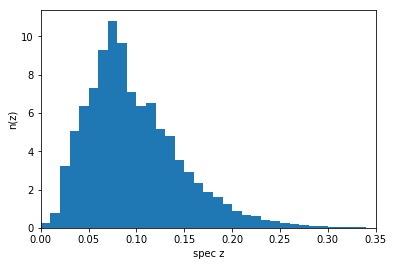

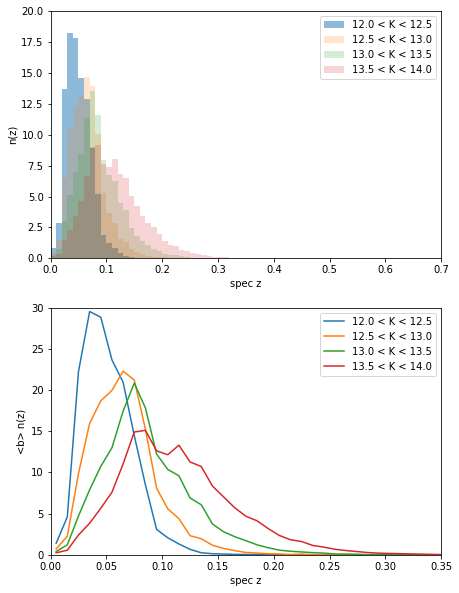

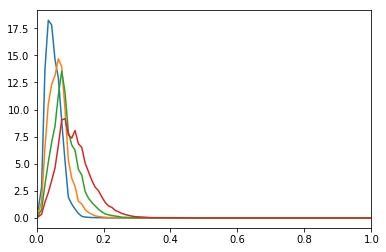

In [266]:
#zbin, dz = np.linspace(0.0, 10.0, 1001, retstep=True)
#zcenter = zbin[:-1] + dz/2.
mask_k = (mask_k1 |mask_k2 |mask_k3 |mask_k4 )
fig, ax = plt.subplots()
N_all, _,_ = ax.hist( sdss_spec['Z'][mask_k], bins=zbin, normed=True)
ax.set_xlabel('spec z')
ax.set_ylabel('n(z)')
ax.set_xlim(0, 0.35)
#ax.set_ylim(0,20)

fig, (ax, ax2) = plt.subplots(2,1,figsize = (7,10))
N1,_, _ = ax.hist( sdss_spec['Z'][mask_k1], bins=zbin, alpha = 0.5, normed=True, label = '12.0 < K < 12.5')
N2,_, _ = ax.hist( sdss_spec['Z'][mask_k2], bins=zbin, alpha = 0.2, normed=True, label = '12.5 < K < 13.0')
N3,_, _ = ax.hist( sdss_spec['Z'][mask_k3], bins=zbin, alpha = 0.2, normed=True, label = '13.0 < K < 13.5')
N4,_, _ = ax.hist( sdss_spec['Z'][mask_k4], bins=zbin, alpha = 0.2, normed=True, label = '13.5 < K < 14.0')
ax.legend()
ax.set_xlabel('spec z')
ax.set_ylabel('n(z)')
ax.set_xlim(0, 0.7)
ax.set_ylim(0,20)

ax2.plot( zbin[:-1] + 0.005, b_avg[0] *N1, label = '12.0 < K < 12.5')
ax2.plot( zbin[:-1] + 0.005, b_avg[1] *N2, label = '12.5 < K < 13.0')
ax2.plot( zbin[:-1] + 0.005, b_avg[2] *N3, label = '13.0 < K < 13.5')
ax2.plot( zbin[:-1] + 0.005, b_avg[3] *N4, label = '13.5 < K < 14.0')
ax2.set_xlabel('spec z')
ax2.set_ylabel('<b> n(z)')
ax2.set_xlim(0, 0.35)
ax2.set_ylim(0,30)
ax2.legend()

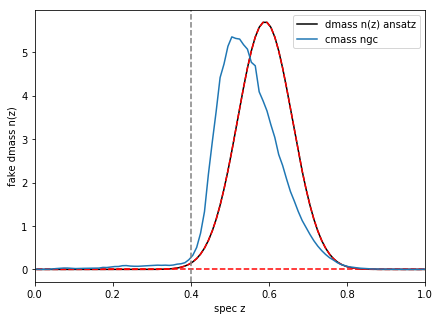

In [58]:
#zbin, dz = np.linspace(0.0, 10.0, 1001, retstep=True)

fig, ax = plt.subplots(1,1,figsize = (7,5))

A = 1.0
ax.plot(zcenter, Pnz_dmass(zcenter,1 ,A=A), 'k-', label = 'dmass n(z) ansatz')
ax.plot(zcenter, A*z_gaussian(0.59, 0.07, zcenter), 'r--')
ax.plot(zcenter, (1.-A)*z_gaussian(0.4, 0.3, zcenter), 'r--')

ax.plot(zcenter, Pnz_cmass(zcenter,1), label = 'cmass ngc')
#N_cmass,_, _ = ax.hist( cmass_spec['Z'], bins=zbin, alpha = 0.5, normed=True, label = 'cmass ngc')
ax.axvline(x = 0.4, color='grey', linestyle='--')

dmass_frac = scipy.integrate.simps(Pnz_dmass(zcenter, 1, A = A)[:40], dx = dz )*100
cmass_frac = scipy.integrate.simps(Pnz_cmass(zcenter, 1)[:40], dx = dz )*100

#ax.text(0.02, 3, ' fraction of sample at z < 0.4 \n - cmass : {:0.2f}% \n - dmass : {:0.2f}%'\
#        .format(cmass_frac, dmass_frac), fontsize = 15)
ax.set_xlabel('spec z')
ax.set_ylabel('fake dmass n(z)')
ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 0.5)
ax.legend(loc='best')

In [7]:
import camb
from camb import model, initialpower

In [41]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()

h0=0.677
omb = 0.048
om = 0.31
omc = om - omb
pars.set_cosmology(H0=100*h0, ombh2=omb*h0**2, omch2 =omc*h0**2, omk=0.0, YHe = 0.245341, tau = 0.08,
                   num_massive_neutrinos = 1)
pars.set_dark_energy()
pars.InitPower.set_params(As=2.26e-9, ns=0.96)
results = camb.get_results(pars)

#units
cc = 299792.5
H0 = 100 
coverH0 = cc/H0
h0 = pars.H0/100.

# matter power spectrum interpolation
PK = camb.get_matter_power_interpolator\
(pars, zmin=0, zmax=10, nz_step = 101, nonlinear=True, 
 hubble_units=True, k_hunit=True, kmax=1000, log_interp = True)
    

In [44]:
pars.set_matter_power(redshifts=[0.], kmax=10.0)
results = camb.get_results(pars)
print results.get_sigma8()

[0.84358232]


[0.81701556]


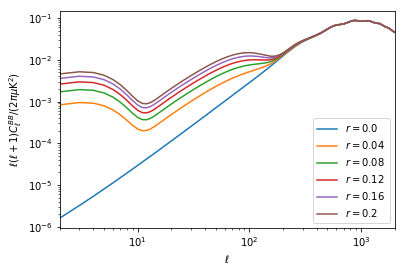

In [18]:
#You can calculate spectra for different primordial power spectra without recalculating everything
#for example, let's plot the BB spectra as a function of r
pars.set_for_lmax(4000, lens_potential_accuracy=1)
pars.WantTensors = True
results = camb.get_transfer_functions(pars)
lmax=2000
rs = np.linspace(0,0.2,6)
for r in rs:
    inflation_params = initialpower.InitialPowerParams()
    inflation_params.set_params(ns=0.96, r=r)
    results.power_spectra_from_transfer(inflation_params)
    cl = results.get_total_cls(lmax, CMB_unit='muK')
    plt.loglog(np.arange(lmax+1),cl[:,2])
plt.xlim([2,lmax])
plt.legend(["$r = %s$"%r for r in  rs], loc='lower right');
plt.ylabel(r'$\ell(\ell+1)C_\ell^{BB}/ (2\pi \mu{\rm K}^2)$')
plt.xlabel(r'$\ell$');

In [22]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
#pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)

pars.set_cosmology(H0=100*h0, ombh2=omb*h0**2, omch2 =omc*h0**2, omk=0.0, YHe = 0.245341, tau = 0.08,
                   num_massive_neutrinos = 1)

pars.set_dark_energy() #re-set defaults
pars.InitPower.set_params(As=2.26e-9, ns=0.96)
#Not non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)

Note: redshifts have been re-sorted (earliest first)


In [23]:
s8

array([0.56190748, 0.84356124])

In [ ]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.set_dark_energy() #re-set defaults
pars.InitPower.set_params(ns=0.965)
#Not non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
s8 = np.array(results.get_sigma8())

In [15]:
print results.get_sigma8()

CAMBError: must have Params.WantTransfer to get matter transfers and power

### cmass vs 2mass forecast

In [61]:
theta = np.logspace(np.log10(0.1/60), np.log10(300./60), 100)

In [80]:
w_matter_2d_interp = w_matter_interp(theta)

In [85]:
wproj1 = w_project(theta, w_matter_2d_interp, 1)
wproj2 = w_project(theta, w_matter_2d_interp, 2)
wproj3 = w_project(theta, w_matter_2d_interp, 3)
wproj4 = w_project(theta, w_matter_2d_interp, 4)

wproj_1bin = w_project_1bin(theta, w_matter_2d_interp, 1)
wproj_cmass = w_cmass_project_1bin(theta, w_matter_2d_interp, 1)

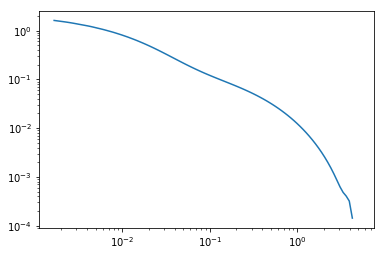

In [86]:
fig, ax = plt.subplots()
ax.loglog(theta, wproj_cmass)
dat = np.column_stack((theta, wproj_cmass))
np.savetxt('../data_txt/acf_cmass_ngc_theory_bias.txt', dat)


In [13]:
As = np.linspace(0.5, 1.0, 51)
modelv_dat1 = []
modelv_dat2 = []
modelv_dat3 = []
modelv_dat4 = []
modelv_1bin = []
for A in As :
    modelv_dat1.append( w_project_A( theta, w_matter_2d_interp, 1,  A=A ) )
    modelv_dat2.append( w_project_A( theta, w_matter_2d_interp, 2,  A=A ) )
    modelv_dat3.append( w_project_A( theta, w_matter_2d_interp, 3,  A=A ) )
    modelv_dat4.append( w_project_A( theta, w_matter_2d_interp, 4,  A=A ) )
    modelv_1bin.append( w_project_A_1bin(theta, w_matter_2d_interp, 1, A =A))
    

modelv_dat1 = np.array(modelv_dat1)
modelv_dat2 = np.array(modelv_dat2)
modelv_dat3 = np.array(modelv_dat3)
modelv_dat4 = np.array(modelv_dat4)
modelv_dat_1bin = np.array(modelv_1bin)

In [14]:
modelv1_interp = interp_2d( theta, As, modelv_dat1)
modelv2_interp = interp_2d( theta, As, modelv_dat2)
modelv3_interp = interp_2d( theta, As, modelv_dat3)
modelv4_interp = interp_2d( theta, As, modelv_dat4)

modelv_interp = [0, modelv1_interp, modelv2_interp, modelv3_interp, modelv4_interp]

modelv_1bin_interp = interp_2d( theta, As, modelv_dat_1bin)
modelv_1bin_interp = [modelv_1bin_interp]

In [85]:
def chisquare_cmass(indz, modelv_interp, prefix=None):
    
    dat1 = prefix+'_k{}'.format(indz)

    meanr, datav, _ = np.genfromtxt(dat1+'.txt', unpack=True)
    cov = np.loadtxt(dat1+'.cov')
    covinv = np.linalg.inv(cov)
    Ass = np.linspace(0.7, 1.0, 1001)
    
    i=0
    chi2 = []
    for A in Ass : 
        modelv = modelv_interp[indz](meanr, A)
        vdiff = (datav - modelv)
        res = np.dot(np.dot( vdiff, covinv ), vdiff)
        chi2.append(res)
        i+=1
    
    #fig, ax = plt.subplots()
    #ax.plot(Ass, chi2)
    #ax.set_xlabel('A')
    
    ind = np.argmin(chi2)
    print 'bestfit A= {:0.4f}'.format(Ass[ind]), 'errA={:0.4f}'.format(1./np.sqrt(chi2[ind])), ' chi2=', chi2[ind], ' chi2_redx=', chi2[ind]/vdiff.size
    return Ass[ind], 1./np.sqrt(chi2[ind])


def chisquare_dmass(indz, modelv_interp, prefix=None):
    
    dat = prefix+'_k{}'.format(indz)

    meanr, datav, _ = np.genfromtxt(dat+'.txt', unpack=True)
    cov = np.loadtxt(dat+'.cov')
    covinv = np.linalg.inv(cov)
    
    #theta = np.logspace(np.log10(2.5), np.log10(250), 20)
    Ass = np.linspace(0.5, 1.0, 501)
    
    i=0
    chi2 = []
    for A in Ass : 
        modelv = modelv_interp[indz](meanr, A)
        vdiff = (datav - modelv)
        res = np.dot(np.dot( vdiff, covinv ), vdiff)
        #res = np.sum(vdiff**2*1./cov.diagonal())
        chi2.append(res)
        i+=1
        
    ind = np.argmin(chi2)   
    
    print 'bestfit A= {:0.4f}'.format(Ass[ind]), 'errA={:0.4f}'.format(1./np.sqrt(chi2[ind])), ' chi2=', chi2[ind], ' chi2_redx=', chi2[ind]/vdiff.size
    return Ass[ind], 1./np.sqrt(chi2[ind])


def find_nearest(array, value, brell):
    
    ind_min = array.argmin()
    array1 = np.asarray(array[:ind_min])
    idx1 = (np.abs(array1 - value)).argmin()
    
    array2 = np.asarray(array[ind_min:])
    idx2 = (np.abs(array2 - value)).argmin()
    
    return brell[:ind_min][idx1], brell[ind_min], brell[ind_min:][idx2]

def fitting_chisquare_cmass(indz, modelv_interp, datav_filename=None):

    meanr, datav, _ = np.genfromtxt(datav_filename, unpack=True)
    cov = np.loadtxt(datav_filename.split('.txt')[0]+'.cov')
    covinv = np.linalg.inv(cov)
    
    Ass = np.linspace(0.5, 1.0, 10000)
    
    i=0
    chi2 = np.zeros(Ass.size)
    for A in Ass : 
        modelv = modelv_interp[indz](meanr, A)
        vdiff = (datav - modelv)
        chi2[i] = np.dot(np.dot( vdiff, covinv ), vdiff)
        #chi2.append(res)
        i+=1
    
    chi2_min = chi2.min()
    #ind = chi2.argmin() #np.argmin(chi2)
    #Abest = Ass[ind]
    A1, Amin, A2 = find_nearest( chi2, chi2_min + 1, Ass )
    errA = np.abs(Amin - A1)
    #print 'bestfit A= {:0.4f}'.format(Ass[ind]), 'errA={:0.4f}'.format(1./np.sqrt(chi2[ind])), ' chi2=', chi2[ind], ' chi2_redx=', chi2[ind]/vdiff.size
    print 'A1, Abest, A2', A1, Amin, A2
    print 'bestfit A= {:0.4f}'.format(Amin), 'errA={:0.4f}'.format(errA), ' chi2=', chi2_min


    #fig, ax = plt.subplots()
    #ax.plot(Ass, chi2)
    #ax.axvline(x=Amin-errA)
    #ax.axvline(x=Amin+errA)
    #ax.set_xlabel('A')
    
    #return Ass[ind], 1./np.sqrt(chi2[ind])
    return Amin, errA, chi2



A1, Abest, A2 0.94558 1.0 1.0
bestfit A= 1.0000 errA=0.0544  chi2= 11.286413009409591
A1, Abest, A2 0.93814 0.98746 1.0
bestfit A= 0.9875 errA=0.0493  chi2= 6.813681189448455
A1, Abest, A2 0.88774 0.9277599999999999 0.96784
bestfit A= 0.9278 errA=0.0400  chi2= 14.595597049065278
A1, Abest, A2 0.8356 0.87262 0.90964
bestfit A= 0.8726 errA=0.0370  chi2= 17.38282621522987


(0.87262,
 0.03701999999999994,
 array([39.1230727 , 39.10796397, 39.0928605 , ..., 29.19212588,
        29.20326588, 29.21441114]))

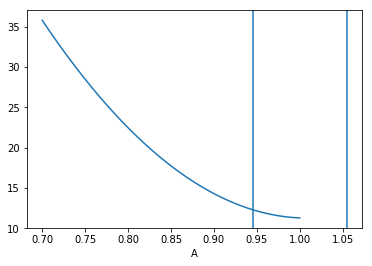

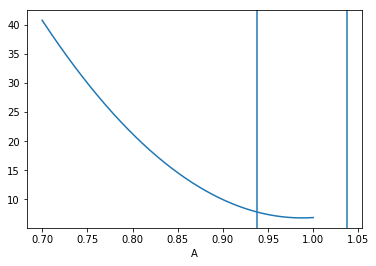

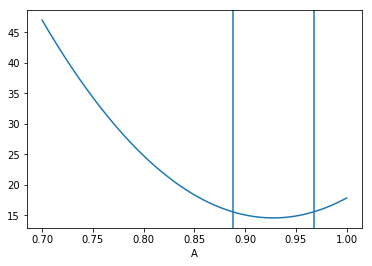

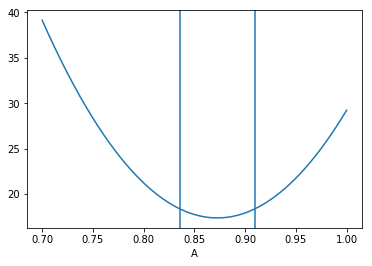

In [60]:
fitting_chisquare_cmass(1, modelv_interp, datav_filename='../data_txt/acf_cross_2mass_x_cmass_ngc_no3_k1.txt')
fitting_chisquare_cmass(2, modelv_interp, datav_filename='../data_txt/acf_cross_2mass_x_cmass_ngc_no3_k2.txt')
fitting_chisquare_cmass(3, modelv_interp, datav_filename='../data_txt/acf_cross_2mass_x_cmass_ngc_no3_k3.txt')
fitting_chisquare_cmass(4, modelv_interp, datav_filename='../data_txt/acf_cross_2mass_x_cmass_ngc_no3_k4.txt')

In [93]:
prefix = '../data_txt/acf_cross_2mass_x_cmass_ngc_no3'
bestfit_A1, errA1 = chisquare_cmass(1, modelv_interp, prefix=prefix)
bestfit_A2, errA2 = chisquare_cmass(2, modelv_interp, prefix=prefix)
bestfit_A3, errA3 = chisquare_cmass(3, modelv_interp, prefix=prefix)
bestfit_A4, errA4 = chisquare_cmass(4, modelv_interp, prefix=prefix)
bestfit_A = [bestfit_A1, bestfit_A2, bestfit_A3, bestfit_A4 ]
errA = [errA1,errA2,errA3,errA4]

TypeError: 'numpy.ndarray' object is not callable

In [323]:
prefix = '../data_txt/acf_cross_2mass_x_dmass_spt_no5'
bestfit_Ad1, errAd1 = chisquare_dmass(1, modelv_interp, prefix=prefix)
bestfit_Ad2, errAd2 = chisquare_dmass(2, modelv_interp, prefix=prefix)
bestfit_Ad3, errAd3 = chisquare_dmass(3, modelv_interp, prefix=prefix)
bestfit_Ad4, errAd4 = chisquare_dmass(4, modelv_interp, prefix=prefix)
bestfit_Ad = [bestfit_Ad1, bestfit_Ad2, bestfit_Ad3, bestfit_Ad4 ]
errAd = [errAd1,errAd2,errAd3,errAd4]

bestfit A= 0.6120 errA=0.3356  chi2= 8.877447505300768  chi2_redx= 0.4438723752650384
bestfit A= 0.8820 errA=0.4888  chi2= 4.185446422608465  chi2_redx= 0.20927232113042327
bestfit A= 0.8950 errA=0.2745  chi2= 13.272667465475909  chi2_redx= 0.6636333732737955
bestfit A= 0.9610 errA=0.2678  chi2= 13.947548735312187  chi2_redx= 0.6973774367656094


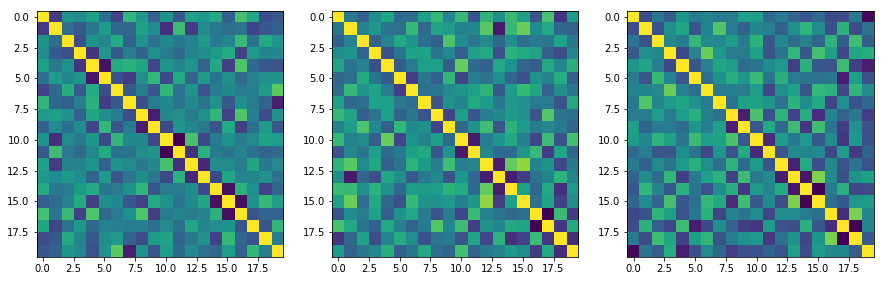

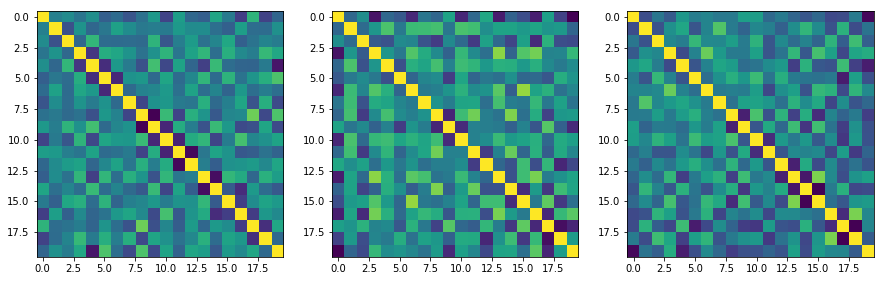

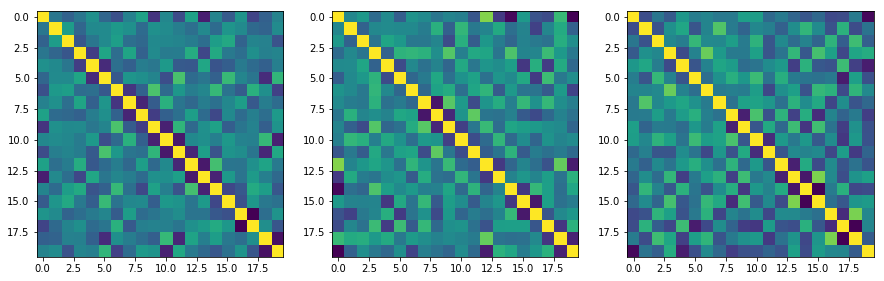

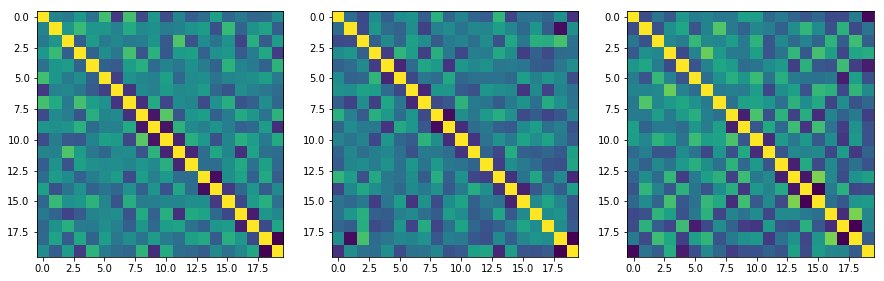

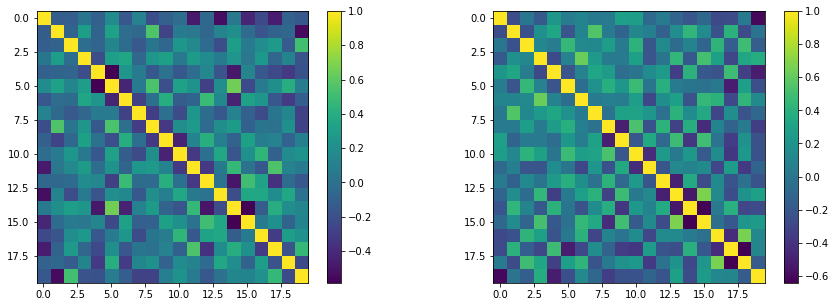

In [175]:
for i in range(1,5):
    cov = np.loadtxt('../data_txt/acf_cross_2mass_x_cmass_ngc_no3_k{}.cov'.format(i))
    cov2 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_no5_k{}.cov'.format(i))
    #cov3 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_no6_k{}.cov'.format(i))
    cov3 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_no7_k{}.cov'.format(0))
    fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize = (15,21))
    ax.imshow(np.corrcoef(cov) )
    ax2.imshow(np.corrcoef(cov2))
    ax3.imshow(np.corrcoef(cov3))


cov4 = np.loadtxt('../data_txt/acf_cross_2mass_x_cmass_ngc_no4_k0.cov')
cov5 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_no7_k0.cov')
fig, (ax, ax2) = plt.subplots(1,2,figsize=(15,5))
im = ax.imshow(np.corrcoef(cov4))
im2 = ax2.imshow(np.corrcoef(cov5))
fig.colorbar(im, ax=ax)
fig.colorbar(im2, ax=ax2)

NameError: name 'bestfit_A' is not defined

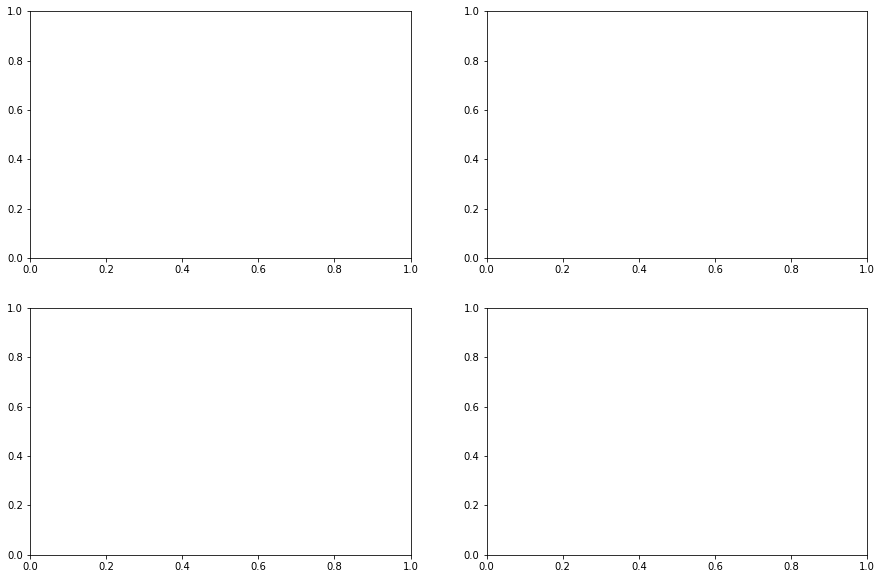

In [92]:
#meanr, xi, xi_err = np.loadtxt('../data_txt/acf_cross_2mass_x_cmass_ngc_k1.txt', unpack=True)
#meanr2, xi2, xi_err2 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_midz_no1.txt',unpack=True)


label = [r'$12.0 < K_{20} < 12.5$', r'$12.5 < K_{20} < 13.0$',\
         r'$13.0 < K_{20} < 13.5$', r'$13.5 < K_{20} < 14.0$']

wproj = [wproj1,wproj2,wproj3,wproj4 ]

fig, ax = plt.subplots(2, 2, figsize = (15,10))
ax = ax.ravel()
for i in range(1, 5):
    
    dat1 = '../data_txt/acf_cross_2mass_x_cmass_ngc_no3_k{}'.format(i)
    dat2 = '../data_txt/acf_cross_2mass_x_dmass_spt_no5_k{}'.format(i)
    
    meanr, xi, xi_err = np.loadtxt(dat1+'.txt', unpack=True)
    meanr2, xi2, xi_err2 = np.loadtxt(dat2+'.txt',unpack=True)
    
    cov = np.loadtxt(dat1+'.cov')
    cov2 =  np.loadtxt(dat2+'.cov')
    
    wprojA = modelv_interp[i](theta, bestfit_A[i-1])
    wprojAd = modelv_interp[i](theta, bestfit_Ad[i-1])
    
    ax[i-1].axhline(y=0, color='grey', linestyle='--')
    ax[i-1].semilogx(theta*60, wproj[i-1],'k-', label = 'theory CMASS')
    ax[i-1].errorbar(meanr*60, xi, yerr = xi_err, fmt = '.', label='2MASS x C')
    ax[i-1].errorbar(meanr2*60*1.05, xi2, yerr = xi_err2, fmt = '.', label='2MASS x D')
    #ax[i-1].semilogx(theta*60, wprojA,'--', color = ax[i-1].lines[-2].get_color(), label = 'bestfit CMASS')
    ax[i-1].semilogx(theta*60, wprojAd,'--', color = ax[i-1].lines[-1].get_color(), label = 'bestfit DMASS')
    
    #ax[i-1].text(20, -0.02, r'$A_c$={:0.3f}  $A_d$={:0.3f}'.format(bestfit_A[i-1], bestfit_Ad[i-1]), fontsize = 15)
    #ax[i-1].text(20, -0.03, r'$err A_c$={:0.3f}  $err A_d$={:0.3f}'.format(errA[i-1], errAd[i-1]), fontsize = 15)
    
    ax[i-1].text(20, -0.03, r'$A_d$={:0.3f},  $errA_d$={:0.3f}'.format(bestfit_Ad[i-1], errAd[i-1]), fontsize = 15)
    #ax[i-1].text(20, -0.03, r'$err A_c$={:0.3f}  $err A_d$={:0.3f}'.format(errA[i-1], errAd[i-1]), fontsize = 15)
    
    ax[i-1].text(20, -0.045, label[i-1], fontsize = 15)

    ax[i-1].set_ylim(-0.05, 0.08)
    ax[i-1].set_xlim(2.5, 250)
    ax[i-1].set_xlabel(r'$\theta$ (arcmin)')
    ax[i-1].set_ylabel(r'cross $w(\theta)$')
    ax[i-1].legend(loc='best')

fig.subplots_adjust(wspace=0.2, hspace=0)

In [338]:
import numpy as np
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)
def eigenstats(x):
    print np.linalg.eigvals(x).min(), np.linalg.eigvals(x).max()
    print np.linalg.eigvals(x).min()/np.linalg.eigvals(x).max()

In [343]:
print is_pos_def(cov)
eigenstats(cov)

True
2.381849348386725e-06 6.557534469813361e-05
0.036322330585545765


In [89]:

prefix1 = '../data_txt/acf_cross_2mass_x_cmass_ngc_no5'
#bestfit_A_1bin, errA = chisquare_cmass(0, modelv_1bin_interp, prefix=prefix1)
bestfit_A_1bin, errA, chisquare_cmass = fitting_chisquare_cmass(0, modelv_1bin_interp, datav_filename='../data_txt/acf_cross_2mass_x_cmass_ngc_no5_k0.txt')

prefix2 = '../data_txt/acf_cross_2mass_x_dmass_spt_no10'
#bestfit_Ad_1bin, errAd = chisquare_dmass(0, modelv_1bin_interp, prefix=prefix2)
bestfit_Ad_1bin, errAd, chisquare_cmass_d = fitting_chisquare_cmass(0, modelv_1bin_interp, datav_filename='../data_txt/acf_cross_2mass_x_dmass_spt_no10_k0.txt')

A1, Abest, A2 0.9139413941394139 0.9427442744274428 0.9715471547154715
bestfit A= 0.9427 errA=0.0288  chi2= 9.110009888008925
A1, Abest, A2 0.8114811481148114 0.8945394539453946 0.9775977597759776
bestfit A= 0.8945 errA=0.0831  chi2= 13.7192576776972


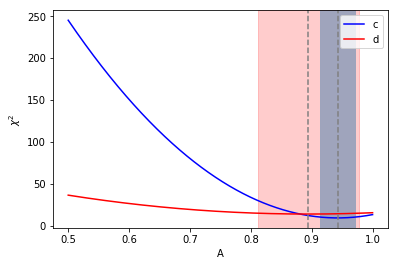

In [87]:
fig, ax = plt.subplots()

Ass = np.linspace(0.5, 1.0, 10000)

ax.plot(Ass, chisquare_cmass, '-b', label='c')
ax.plot(Ass, chisquare_cmass_d, '-r',label='d')
#ax.plot(Ass, chisqr_result_sd, '-g',label='S-d')

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)
ax.axvspan(bestfit_A_1bin- errA, bestfit_A_1bin + errA, alpha=0.99, color='skyblue')
ax.axvspan(bestfit_Ad_1bin- errAd, bestfit_Ad_1bin+ errAd,alpha=0.2, color='red')

ax.axvline(x=bestfit_A_1bin, color = 'grey', ls='--')
ax.axvline(x=bestfit_Ad_1bin, color = 'grey', ls='--')

ax.set_xlabel(r'A')
ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.axhline(y = chisqr_min_ns+1)
#ax.axhline(y = chisqr_min_nd+1)
#ax.axhline(y = chisqr_min_sd+1)


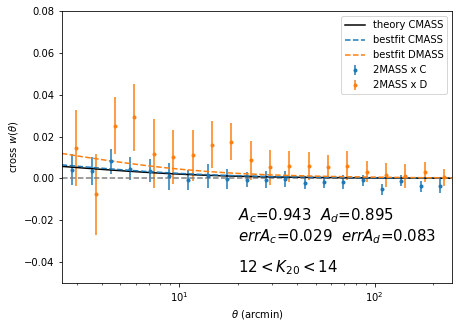

In [91]:
"""

prefix1 = '../data_txt/acf_cross_2mass_x_cmass_ngc_no5'
bestfit_A_1bin, errA = chisquare_cmass(0, modelv_1bin_interp, prefix=prefix1)

prefix2 = '../data_txt/acf_cross_2mass_x_dmass_spt_no10'
bestfit_Ad_1bin, errAd = chisquare_dmass(0, modelv_1bin_interp, prefix=prefix2)

label = [r'$12.0 < K_{20} < 12.5$', r'$12.5 < K_{20} < 13.0$',\
         r'$13.0 < K_{20} < 13.5$', r'$13.5 < K_{20} < 14.0$']
"""

fig, ax = plt.subplots(figsize = (7,5))

i=0
prefix1 = '../data_txt/acf_cross_2mass_x_cmass_ngc_no5'
prefix2 = '../data_txt/acf_cross_2mass_x_dmass_spt_no10'
dat1 = prefix1+'_k{}'.format(0)
dat2 = prefix2+'_k{}'.format(0)

meanr, xi, xi_err = np.loadtxt(dat1+'.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(dat2+'.txt',unpack=True)

cov = np.loadtxt(dat1+'.cov'.format(i))
cov2 =  np.loadtxt(dat2+'.cov'.format(i))
invcov = np.linalg.inv(cov)
invcov2 = np.linalg.inv(cov2)



wprojA = modelv_1bin_interp[0](meanr, bestfit_A_1bin)
wprojAd = modelv_1bin_interp[0](meanr2, bestfit_Ad_1bin)

DAT = np.column_stack(( meanr, wprojA ))
np.savetxt(prefix1 + '.theory', DAT, header = 'meanr xi')

DAT = np.column_stack(( meanr2, wprojAd ))
np.savetxt(prefix2 + '.theory', DAT, header = 'meanr xi')

ax.axhline(y=0, color='grey', linestyle='--')
ax.semilogx(theta*60, wproj_1bin,'k-', label = 'theory CMASS')
ax.errorbar(meanr*60, xi, yerr = xi_err, fmt = '.', label='2MASS x C')
ax.errorbar(meanr2*60*1.05, xi2, yerr = xi_err2, fmt = '.', label='2MASS x D')
ax.semilogx(theta*60, wprojA,'--', color = ax.lines[-2].get_color(), label = 'bestfit CMASS')
ax.semilogx(theta*60, wprojAd,'--', color = ax.lines[-2].get_color(), label = 'bestfit DMASS')

ax.text(20, -0.02, r'$A_c$={:0.3f}  $A_d$={:0.3f}'.format(bestfit_A_1bin, bestfit_Ad_1bin), fontsize = 15)
ax.text(20, -0.03, r'$err A_c$={:0.3f}  $err A_d$={:0.3f}'.format(errA, errAd), fontsize = 15)
ax.text(20, -0.045, r'$12 < K_{20} < 14$', fontsize = 15)

ax.set_ylim(-0.05, 0.08)
ax.set_xlim(2.5, 250)
ax.set_xlabel(r'$\theta$ (arcmin)')
ax.set_ylabel(r'cross $w(\theta)$')
ax.legend(loc='best')

fig.subplots_adjust(wspace=0.2, hspace=0)